<a href="https://colab.research.google.com/github/The1AndOnlyAlex/PyTorch-MNIST/blob/main/pytorch3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
import torch
import torch.nn as nn
from torch.optim import SGD
import numpy as np
import matplotlib.pyplot as plt

It turns out the previous model was not very good at all. There were 24 parameters across the two matricies but there was only technically two independent parameters because:
$A_2A_1 = B$

where $B$ is a $2 x 1$ matrix. So really our function was $f(x) = Bx$

In [69]:
# Previous neural network:
x = torch.tensor([[6,2],[5,2],[1,3],[7,6]]).float()
y = torch.tensor([1,5,2,5]).float()

class MyNeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.Matrix1 = nn.Linear(2,8,bias=False)
        self.Matrix2 = nn.Linear(8,1,bias=False)
    def forward(self,x):
        x = self.Matrix1(x)
        x = self.Matrix2(x)
        return x.squeeze()

f = MyNeuralNet()
opt = SGD(f.parameters(), lr=0.001)
L = nn.MSELoss()

# Train model
losses = []
for _ in range(50):
    opt.zero_grad() # flush previous epoch's gradient
    loss_value = L(f(x), y) #compute loss
    loss_value.backward() # compute gradient
    opt.step() # Perform iteration using gradient above
    losses.append(loss_value.item())

In [70]:
y

tensor([1., 5., 2., 5.])

In [71]:
f(x)

tensor([2.8429, 2.5420, 1.8569, 5.2184], grad_fn=<SqueezeBackward0>)

# **How can we use the simplicity of linear algebra but have advanced models?**

The Crux of Machine learning: This lies in so-called activation functions, which add ever-so-slight non-linearities to a sequence of matrix transformations. Instead of:

$f(x) = A_2A_1x$

consider instead

$f_2(x) = A_2R(A_1x)$

where $R$ is an element-wise operator defined by

$R(x) = \left\{
\begin{aligned}
& x \quad x > 0 \\
& 0 \quad x <= 0 \\
\end{aligned}
\right.$

In [72]:
x = torch.tensor([[4,6,2,-1,6,2,5],[1,6,2,-6,5,-3,5]])
x

tensor([[ 4,  6,  2, -1,  6,  2,  5],
        [ 1,  6,  2, -6,  5, -3,  5]])

In [73]:
R = nn.ReLU()
R(x)

tensor([[4, 6, 2, 0, 6, 2, 5],
        [1, 6, 2, 0, 5, 0, 5]])

In [74]:
# Another example
x = torch.linspace(-3,3,100)
y = R(x)

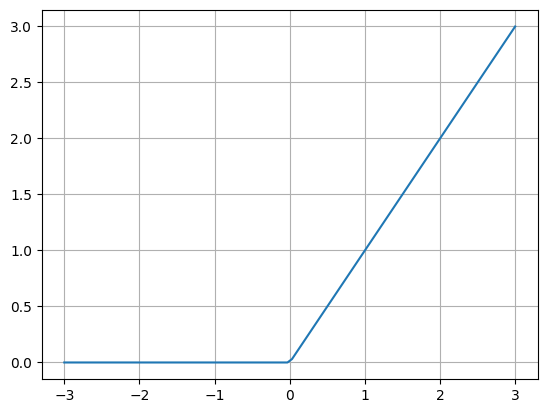

In [75]:
plt.plot(x.numpy(), y.numpy())
plt.grid()
plt.show()

How much better does the model do with this simple adjustment?

In [76]:
class MyNeuralNet2(nn.Module):
  def __init__(self):
    super().__init__()
    self.Matrix1 = nn.Linear(2,8,bias=False)
    self.Matrix2 = nn.Linear(8,1,bias=False)
    self.R = nn.ReLU()
  def forward(self,x):
    x = self.R(self.Matrix1(x))
    x = self.Matrix2(x)
    return x.squeeze()

Train model

In [77]:
def train_model(x,y,f, n_epochs=50):
  opt = SGD(f.parameters(), lr=0.001)
  L = nn.MSELoss()

  # Train model
  losses = []
  for _ in range(n_epochs):
      opt.zero_grad() # flush previous epoch's gradeint
      loss_value = L(f(x), y) # Compute loss
      loss_value.backward() # Compute gradient
      opt.step() # Perform iternation using gradient above
      losses.append(loss_value.item())
  return f, losses

In [78]:
x = torch.tensor([[6,2],[5,2],[1,3],[7,6]]).float()
y = torch.tensor([1,5,2,5]).float()
f2 = MyNeuralNet2()

# Train model
f2, losses2 = train_model(x,y,f2, n_epochs=5000)

predictions:

In [79]:
y

tensor([1., 5., 2., 5.])

In [80]:
f(x)

tensor([2.8429, 2.5420, 1.8569, 5.2184], grad_fn=<SqueezeBackward0>)

Slightly better. The real advantage of this slight non-linearity is that we can make our matrices much larger. Lets make our matrices size $80 x 2$ and $1 x 80$. This only works because of our non-linearity function $R(x)$:

Without $R(x)$ we would just have $A_2A_2 = B$ and so $f(x) = Bx$ where $B$ is still a $1 x 2$ matrix even though $A_2$ and $A_1$ are larger matrices. The non-linearity function $R(x)$, to some extent, makes all 240 parameters more independent from eachother.

Previous model: $f_2(x) = A_2R(A_1x) \quad A_2$ is $1x8$ and $A_1$ is $8x2$

New model: $f_3(x) = A_2R(A_1x) \quad A_2$ is $1x80$ and $A_1$ is $80x2$

In [81]:
class MyNeuralNet3(nn.Module):
  def __init__(self):
    super().__init__()
    self.Matrix1 = nn.Linear(2,80, bias=False)
    self.Matrix2 = nn.Linear(80,1, bias = False)
    self.R = nn.ReLU()
  def forward(self,x):
    x = self.R(self.Matrix1(x))
    x = self.Matrix2(x)
    return x.squeeze()

Train model:

In [82]:
x = torch.tensor([[6,2],[5,2],[1,3],[7,6]]).float()
y = torch.tensor([1,5,2,5]).float()
f3 = MyNeuralNet3()

# Train model
f3, losses3 = train_model(x,y,f3, n_epochs=5000)

In [83]:
y

tensor([1., 5., 2., 5.])

In [84]:
f3(x)

tensor([1.9607, 3.6477, 1.9169, 5.1594], grad_fn=<SqueezeBackward0>)

Closer? But still not exact.

$f(x) = A_2R(A_1x+b_1)+b_2$

where $b_1$ and $b_2$ are vectors added to each of the linear transformations.

In [85]:
class MyNeuralNet4(nn.Module):
  def __init__(self):
    super().__init__()
    self.Matrix1 = nn.Linear(2,80)
    self.Matrix2 = nn.Linear(80,1)
    self.R = nn.ReLU()
  def forward(self,x):
    x = self.R(self.Matrix1(x))
    x = self.Matrix2(x)
    return x.squeeze()

In [86]:
x = torch.tensor([[6,2],[5,2],[1,3],[7,6]]).float()
y = torch.tensor([1,5,2,5]).float()
f4 = MyNeuralNet4()

# Train model
f4, losses4 = train_model(x,y,f4, n_epochs=5000)

In [87]:
y

tensor([1., 5., 2., 5.])

In [88]:
f4(x)

tensor([1.4160, 4.4916, 2.0340, 5.0147], grad_fn=<SqueezeBackward0>)

One last thing:
What if we add another matrix in the middle?

Previous model: $f_3(x) = A_2R(A_1x+b_1) + b_2 \quad A_2$ is $1x80$ and $A_1$ is $80x2$

New model: $f_3(x) = A_3R(A_2R(A_1x+b_1) + b_2) \quad A_3$ is $1x80$ and $A_2$ is $80x80$ and $A_1$ is $80x2$

In [89]:
class MyNeuralNet5(nn.Module):
  def __init__(self):
    super().__init__()
    self.Matrix1 = nn.Linear(2,80)
    self.Matrix2 = nn.Linear(80,80)
    self.Matrix3 = nn.Linear(80,1)
    self.R = nn.ReLU()
  def forward(self,x):
    x = self.R(self.Matrix1(x))
    x = self.R(self.Matrix2(x))
    x = self.Matrix3(x)
    return x.squeeze()


x = torch.tensor([[6,2],[5,2],[1,3],[7,6]]).float()
y = torch.tensor([1,5,2,5]).float()
f5 = MyNeuralNet5()

opt = SGD(f.parameters(), lr=0.001)
L = nn.MSELoss()


# train model
f5, losses5 = train_model(x,y,f5, n_epochs=5000)

In [90]:
y

tensor([1., 5., 2., 5.])

In [91]:
f5(x)

tensor([1.0004, 4.9991, 2.0000, 5.0000], grad_fn=<SqueezeBackward0>)